In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def create_trajectory(σ, length, T=0.1):
    acceleration = np.random.normal(0, σ, size=length)
    trajectory = np.ones(length) * 5
    velocity = np.zeros(length)
    
    for i in range(1, length):
        velocity[i] = velocity[i-1] + acceleration[i-1] * T
        trajectory[i] = trajectory[i-1] + velocity[i-1] * T + (acceleration[i-1] * T ** 2) / 2 
        
    return trajectory
    
def create_measurement(σ, base_trajectory):
    measurement_noize = np.random.normal(0, σ, size=len(base_trajectory)) 
    trajectory_measured = np.copy(base_trajectory) + measurement_noize
    
    return trajectory_measured

def get_smoothed_running_mean(raw_array, M):
    delay = round((M - 1) / 2)
    trajectory_smooth = np.copy(raw_array)
    
    for i in range(0, delay):
        trajectory_smooth[i] = np.mean(raw_array[:delay])
        
    for i in range(delay, len(raw_array) - delay):
        trajectory_smooth[i] = np.mean(raw_array[(i-delay):i+delay])
        
    for i in range(len(raw_array) - 1, len(raw_array) - delay - 1, -1):
        trajectory_smooth[i] = np.mean(raw_array[-delay:])
        
    return trajectory_smooth

def get_smoothed_exp(raw_array, α, direction="forward"):
    trajectory_smooth = np.copy(raw_array)
    
    if direction == "forward":
        for i in range(1, len(raw_array)):
            delta = raw_array[i] - trajectory_smooth[i-1]
            trajectory_smooth[i] = trajectory_smooth[i-1] + α * (delta)
    else:
        for i in range(len(raw_array) - 2, 0, -1):
            delta = raw_array[i] - trajectory_smooth[i+1]
            trajectory_smooth[i] = trajectory_smooth[i+1] + α * (delta)
        
    return trajectory_smooth

def get_var_coeff(smooth_array):
    Iv = 0

    for i in range(0, array_size - 2):
        Iv += (smooth_array[i+2] - 2 * smooth_array[i+1] + smooth_array[i]) ** 2
    
    return Iv

def get_div_coeff(smooth_array, raw_array):
    tmp_array = np.copy(raw_array)
    tmp_array -= smooth_array
    tmp_array = tmp_array ** 2

    return tmp_array.sum()

In [3]:
σ_a = 10 ** 0.5
σ_m = 500 ** 0.5
array_size = 300
T = 0.1 
time = np.arange(0, 30, T)

trajectory = create_trajectory(σ_a, array_size)
measurement = create_measurement(σ_m, trajectory)

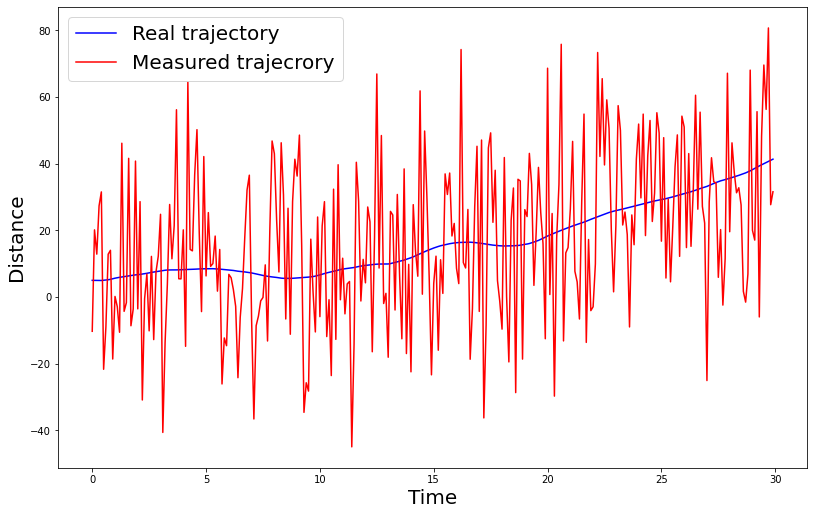

In [39]:
figure = plt.figure(figsize=[8,8])

axes = figure.add_axes([1, 1, 1.3, 0.8])

axes.plot(time, trajectory, "blue")
axes.plot(time, measurement, "red")
axes.set_xlabel("Time", fontsize=20)
axes.set_ylabel("Distance", fontsize=20)
axes.legend(["Real trajectory", "Measured trajecrory"], fontsize=20)

plt.show()

In [60]:
α = 0.08
M = 25

smooth_exp = get_smoothed_exp(measurement, α)
smooth_run = get_smoothed_running_mean(measurement, M)

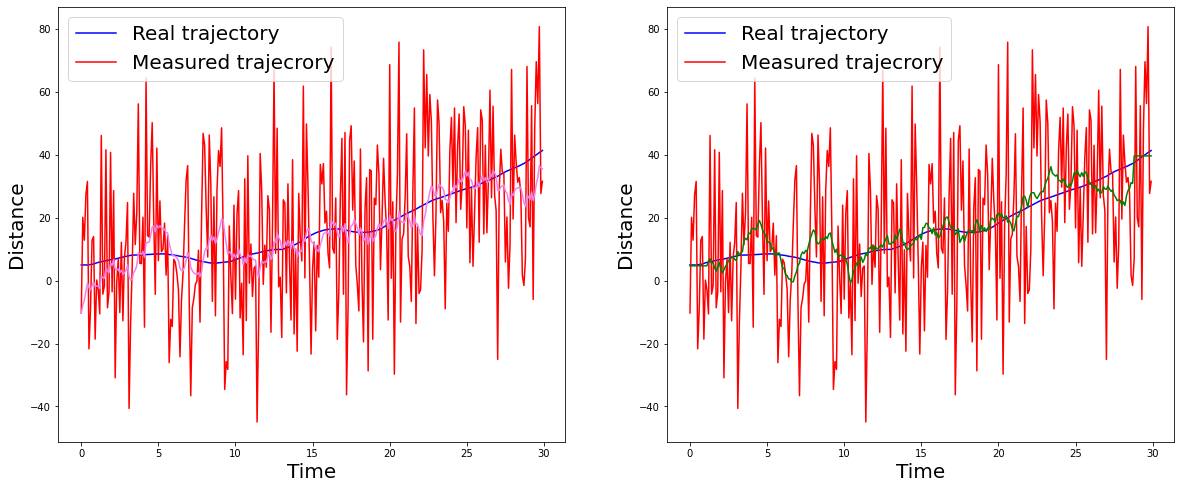

In [61]:
fig, ax = plt.subplots(ncols = 2, figsize=[20,8])

ax[0].plot(time, trajectory, "blue")
ax[0].plot(time, measurement, "red")
ax[0].plot(time, smooth_exp, "violet")
ax[0].set_xlabel("Time", fontsize=20)
ax[0].set_ylabel("Distance", fontsize=20)
ax[0].legend(["Real trajectory", "Measured trajecrory"], fontsize=20)

ax[1].plot(time, trajectory, "blue")
ax[1].plot(time, measurement, "red")
ax[1].plot(time, smooth_run, "green")
ax[1].set_xlabel("Time", fontsize=20)
ax[1].set_ylabel("Distance", fontsize=20)
ax[1].legend(["Real trajectory", "Measured trajecrory"], fontsize=20)

plt.show()

# Second Trajectoty

In [116]:
def create_trajectory_sin(σ, T, size=300):
    trajectory = np.ones(size)
    A = np.ones(size)
    ω = np.random.normal(0, σ, size-1)
    
    A[1:] += ω
    
    for i in range(size):
        trajectory[i] = A[i] * np.sin((2 * np.pi * i / T) + 3)

    return trajectory

In [129]:
T_sin = 32
σ_sin = 0.08
η_sin = 0.05 ** 0.5

trajectory_sin = create_trajectory_sin(σ_sin, T_sin)
measurement_sin = create_measurement(η_sin, trajectory_sin)

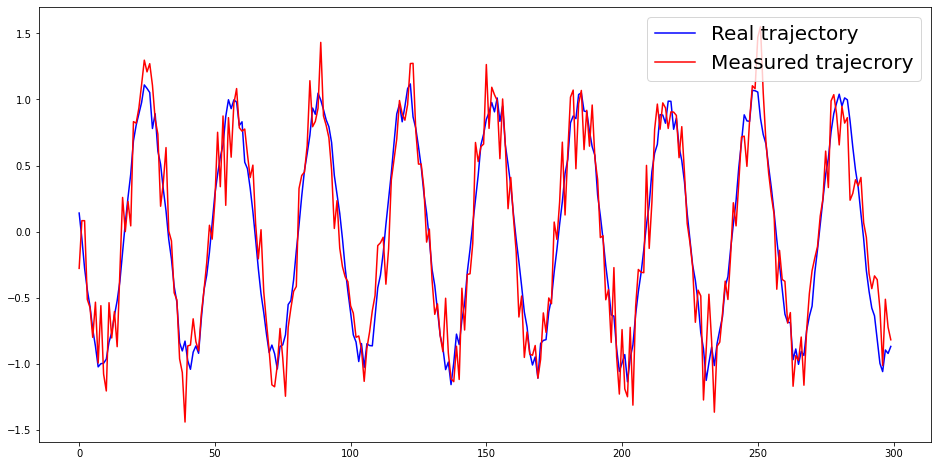

In [130]:
fig, ax = plt.subplots(figsize=[16,8])

ax.plot(trajectory_sin, "blue")
ax.plot(measurement_sin, "red")
ax.legend(["Real trajectory", "Measured trajecrory"], fontsize=20)

plt.show()

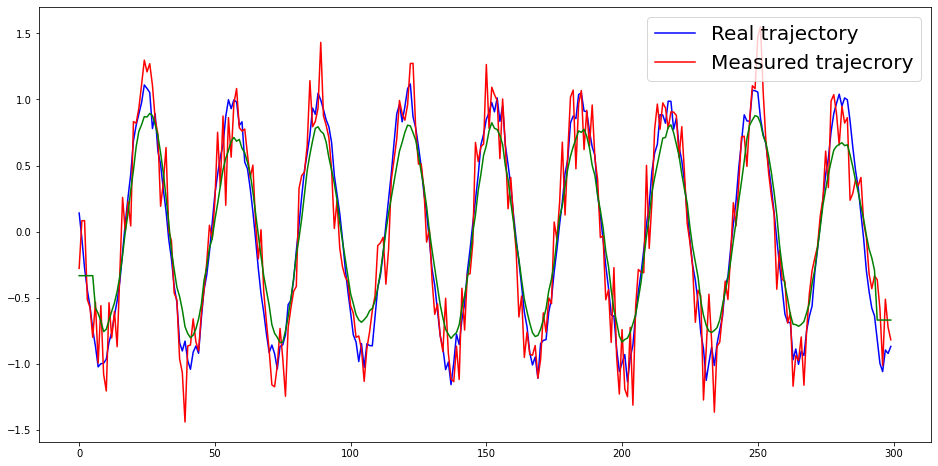

In [131]:
M_sin = 13

smooth_run_sin = get_smoothed_running_mean(measurement_sin, M_sin)

fig, ax = plt.subplots(figsize=[16,8])

ax.plot(trajectory_sin, "blue")
ax.plot(measurement_sin, "red")
ax.plot(smooth_run_sin, "green")
ax.legend(["Real trajectory", "Measured trajecrory"], fontsize=20)

plt.show()

## Small conclusion

Running mean has good results when applied to monotonic curves. But, as is known, at local extrema it has a double error that is proportional to the window size. We can see this on the plot.

In [180]:
M_const = 21

# Find T produces inverse oscillations
inverse = create_trajectory_sin(σ_sin, M_const / 1.5)
smooth_inverse = get_smoothed_running_mean(inverse, M_const)

# Find T leads to the loss of oscillations (zero oscillations)
loss = create_trajectory_sin(σ_sin, M_const)
smooth_loss = get_smoothed_running_mean(loss, M_const)

# Find T changes the oscillations insignificantly 
small = create_trajectory_sin(σ_sin, M_const * 4)
smooth_small = get_smoothed_running_mean(small, M_const)

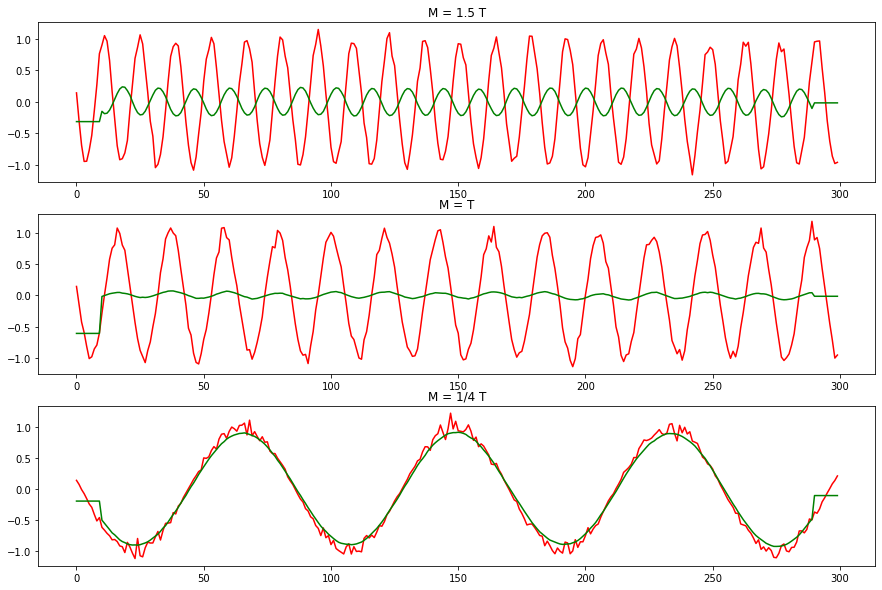

In [188]:
fig, ax = plt.subplots(nrows=3, figsize=[15,10])

ax[0].plot(inverse, "red")
ax[0].plot(smooth_inverse, "green")
ax[0].set(title="M = 1.5 T", )

ax[1].plot(loss, "red")
ax[1].plot(smooth_loss, "green")
ax[1].set(title="M = T")

ax[2].plot(small, "red")
ax[2].plot(smooth_small, "green")
ax[2].set(title="M = 1/4 T")

plt.show()

# Conclusion

* a. To get maximum value of inverse oscillations we should use M  = 1.5 T
* b. To lose all oscillations we should use M = T
* c. To get satisfying result without oscillation loss we should use M  <= 1/4 T